In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv


**Import data, view dataframe structure**

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

df_train = pd.read_csv('/kaggle/input/titanic/train.csv')
df_truetest = pd.read_csv('/kaggle/input/titanic/test.csv')

df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


**Isolate letter in Cabin feature and find where NaNs exist**

Cabin coverage is sparse, but letter is not - may relate to deck and if so may be significant.

In [3]:
CabinLetter = df_train['Cabin']
CabinLetter[CabinLetter.notnull()] = [x[0] for i, x in enumerate(CabinLetter[CabinLetter.notnull()])]

df_train['CabinLetter'] = CabinLetter

X = pd.get_dummies(df_train.drop(columns=['Survived','Name','Ticket','Cabin','PassengerId']))
y = df_train['Survived']
X = X.drop(columns=['Sex_male']) #Sex feature is binary, don't need both
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0) 
X = X_train
y=y_train
X.isna().sum()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Pclass             0
Age              133
SibSp              0
Parch              0
Fare               0
Sex_female         0
Embarked_C         0
Embarked_Q         0
Embarked_S         0
CabinLetter_A      0
CabinLetter_B      0
CabinLetter_C      0
CabinLetter_D      0
CabinLetter_E      0
CabinLetter_F      0
CabinLetter_G      0
CabinLetter_T      0
dtype: int64

**Create dummy classifier as baseline check**

In [4]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

dc_strat = DummyClassifier(strategy = 'stratified').fit(X_train, y_train)

y_dummy_predict = dc_strat.predict(X_test)
confusion = confusion_matrix(y_test, y_dummy_predict)

print('Stratified dummy classifier\n', confusion)
print('Accuracy of dummy classifier',accuracy_score(y_test,y_dummy_predict))

Stratified dummy classifier
 [[83 56]
 [55 29]]
Accuracy of dummy classifier 0.5022421524663677


**Perform logistic regression**

Using a simple imputer to fill in Ages (NA for CabinLetter shows as 0 for all values)
Compare accuracy using ridge method with varying C values

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),('lr',LogisticRegression(solver='liblinear',penalty='l1'))])

param_grid = {
    'lr__C': np.logspace(-4, 6, 10)
}
search = GridSearchCV(pipe, param_grid,cv=5)
search.fit(X, y)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.793):
{'lr__C': 2.782559402207126}


/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


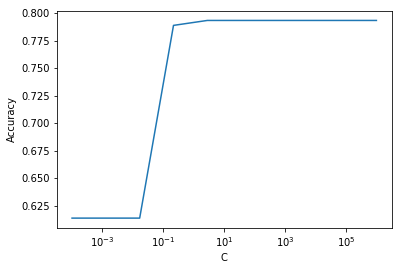

In [6]:
C_vals = [search.cv_results_['params'][i]['lr__C'] for i in range(len(search.cv_results_['params']))]
scores = search.cv_results_['mean_test_score']

plt.figure()
plt.semilogx(C_vals,scores)
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.show()

**Using optimal logistic regression, sort features by coefficient**

In [7]:
from sklearn.model_selection import cross_validate

lrpipe = pipe.set_params(lr__C = 10^3).fit(X,y)
sortind=lrpipe['lr'].coef_.reshape(-1,1).argsort(axis=0)
for features, coefficients in zip(X.columns[sortind], lrpipe['lr'].coef_.reshape(-1,1)[sortind]):
    print(features,coefficients)
print('Accuracy score with simple imputer = ',np.mean(cross_validate(lrpipe, X, y, cv=5)['test_score']))

Age [[-3.0701391]]
SibSp [[-2.92898804]]
CabinLetter_G [[-1.71260143]]
Pclass [[-1.65058014]]
Embarked_S [[-0.36612131]]
Parch [[-0.26190927]]
Embarked_Q [[-0.04307717]]
Embarked_C [[0.04235588]]
CabinLetter_D [[0.08310883]]
CabinLetter_C [[0.26695823]]
Fare [[0.40514679]]
CabinLetter_E [[0.73753483]]
CabinLetter_B [[0.84176564]]
CabinLetter_A [[1.3121731]]
CabinLetter_F [[2.46911582]]
Sex_female [[2.75580667]]
CabinLetter_T [[3.06919561]]
Accuracy score with simple imputer =  0.7934350802379082


**Perform analysis with iterative imputer**

In [8]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

pipei = Pipeline(steps=[('imputer', IterativeImputer()), ('scaler', MinMaxScaler()),('lr',LogisticRegression(solver='liblinear',penalty='l1'))])

param_grid = {
    'lr__C': np.logspace(-4, 6, 10)
}
search = GridSearchCV(pipei, param_grid,cv=5)
search.fit(X, y)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Best parameter (CV score=0.793):
{'lr__C': 464.1588833612782}


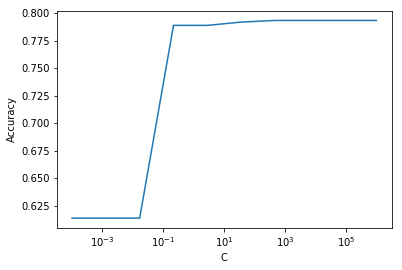

In [9]:
C_vals = [search.cv_results_['params'][i]['lr__C'] for i in range(len(search.cv_results_['params']))]
scores = search.cv_results_['mean_test_score']

plt.figure()
plt.semilogx(C_vals,scores)
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.show()

**Look at feature significance and accuracy for iterative imputer results**

In [10]:
pipei = Pipeline(steps=[('imputer', IterativeImputer()), ('scaler', MinMaxScaler()),('lr',LogisticRegression(solver='liblinear',penalty='l1'))])
lrpipei = pipei.set_params(lr__C = 10^3).fit(X,y)
sortind=lrpipei['lr'].coef_.reshape(-1,1).argsort(axis=0)
for features, coefficients in zip(X.columns[sortind], lrpipei['lr'].coef_.reshape(-1,1)[sortind]):
    print(features,coefficients)
print('Accuracy score with iterative imputer = ',np.mean(cross_validate(lrpipei, X, y, cv=5)['test_score']))

Age [[-3.6622025]]
SibSp [[-3.57347562]]
Pclass [[-1.84148454]]
CabinLetter_G [[-1.77485209]]
Embarked_S [[-0.3439979]]
Parch [[-0.17674738]]
Embarked_Q [[0.]]
CabinLetter_D [[0.01034898]]
Embarked_C [[0.03271045]]
CabinLetter_C [[0.25558282]]
Fare [[0.32142776]]
CabinLetter_E [[0.66058121]]
CabinLetter_B [[0.81570483]]
CabinLetter_A [[1.26226616]]
CabinLetter_F [[2.37487083]]
Sex_female [[2.73283895]]
CabinLetter_T [[2.99637294]]
Accuracy score with iterative imputer =  0.7904387835259792


**Perform SVC analysis for comparison**

In [11]:
from sklearn.svm import SVC

pipe = Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),('svc',SVC())])

param_grid = {
    'svc__C': np.logspace(-1, 2, 10),
    'svc__gamma' : np.logspace(-2,2,10) #These have both been narrowed down from broader+coarser searches
}
search = GridSearchCV(pipe, param_grid,cv=3)
search.fit(X, y)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)



Best parameter (CV score=0.805):
{'svc__C': 46.41588833612777, 'svc__gamma': 1.6681005372000592}


**Visualize how accuracy is affected by C and gamma when other parameter is set to maximum**

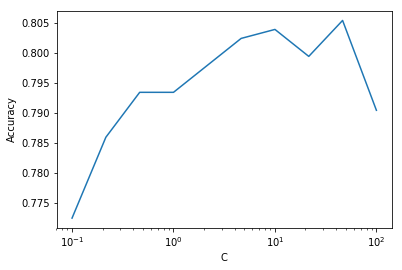

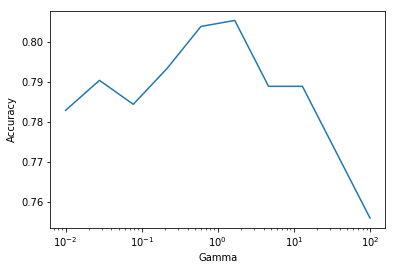

In [12]:
C_vals = [search.cv_results_['params'][i]['svc__C'] for i in range(len(search.cv_results_['params'])) if abs(np.log(search.cv_results_['params'][i]['svc__gamma']) - np.log(search.best_params_['svc__gamma'])) <= 0.1]
scores = [search.cv_results_['mean_test_score'][i] for i in range(len(search.cv_results_['params'])) if abs(np.log(search.cv_results_['params'][i]['svc__gamma']) - np.log(search.best_params_['svc__gamma'])) <= 0.1]

plt.figure()
plt.semilogx(C_vals,scores)
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.show()

g_vals = [search.cv_results_['params'][i]['svc__gamma'] for i in range(len(search.cv_results_['params'])) if abs(np.log(search.cv_results_['params'][i]['svc__C']) - np.log(search.best_params_['svc__C'])) <= 0.1]
scores = [search.cv_results_['mean_test_score'][i] for i in range(len(search.cv_results_['params'])) if abs(np.log(search.cv_results_['params'][i]['svc__C']) - np.log(search.best_params_['svc__C'])) <= 0.1]

plt.figure()
plt.semilogx(g_vals,scores)
plt.xlabel('Gamma')
plt.ylabel('Accuracy')
plt.show()

In [13]:
svcpipe = pipe.set_params(svc__C = 1, svc__gamma = 1.668).fit(X,y)
print('Accuracy score with iterative imputer = ',np.mean(cross_validate(svcpipe, X, y, cv=5)['test_score']))

Accuracy score with iterative imputer =  0.7993940074065762


**Repeat for iterative imputer**

In [14]:
pipei = Pipeline(steps=[('imputer', IterativeImputer()), ('scaler', MinMaxScaler()),('svc',SVC())])

param_grid = {
    'svc__C': np.logspace(-1, 2, 10),
    'svc__gamma' : np.logspace(-2,2,10) #These have both been narrowed down from broader+coarser searches
}
search = GridSearchCV(pipei, param_grid,cv=3)
search.fit(X, y)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)


Best parameter (CV score=0.808):
{'svc__C': 46.41588833612777, 'svc__gamma': 0.5994842503189409}


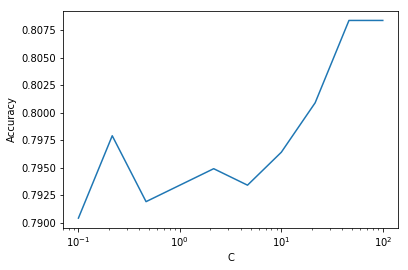

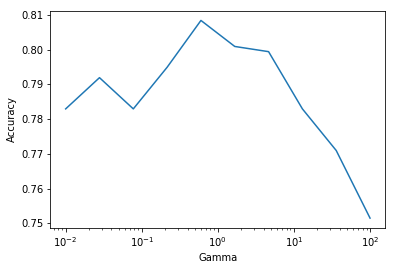

In [15]:
C_vals = [search.cv_results_['params'][i]['svc__C'] for i in range(len(search.cv_results_['params'])) if abs(np.log(search.cv_results_['params'][i]['svc__gamma']) - np.log(search.best_params_['svc__gamma'])) <= 0.1]
scores = [search.cv_results_['mean_test_score'][i] for i in range(len(search.cv_results_['params'])) if abs(np.log(search.cv_results_['params'][i]['svc__gamma']) - np.log(search.best_params_['svc__gamma'])) <= 0.1]

plt.figure()
plt.semilogx(C_vals,scores)
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.show()

g_vals = [search.cv_results_['params'][i]['svc__gamma'] for i in range(len(search.cv_results_['params'])) if abs(np.log(search.cv_results_['params'][i]['svc__C']) - np.log(search.best_params_['svc__C'])) <= 0.1]
scores = [search.cv_results_['mean_test_score'][i] for i in range(len(search.cv_results_['params'])) if abs(np.log(search.cv_results_['params'][i]['svc__C']) - np.log(search.best_params_['svc__C'])) <= 0.1]

plt.figure()
plt.semilogx(g_vals,scores)
plt.xlabel('Gamma')
plt.ylabel('Accuracy')
plt.show()

In [16]:
pipei = Pipeline(steps=[('imputer', IterativeImputer()), ('scaler', MinMaxScaler()),('svc',SVC())])
svcpipe = pipei.set_params(svc__C = 1, svc__gamma = 1.668).fit(X,y)
print('Accuracy score with iterative imputer = ',np.mean(cross_validate(svcpipe, X, y, cv=5)['test_score']))

Accuracy score with iterative imputer =  0.7979014700931433


**Random forest classifier**

In [17]:
from sklearn.ensemble import RandomForestClassifier

piperfc = Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),('rfc',RandomForestClassifier(random_state=53))])

param_grid = {
    'rfc__max_depth': [2,3,4,5,6,7],
    'rfc__min_samples_leaf' : [1,2,3,4,5,6],
    'rfc__n_estimators' : [30,35,40,45]
}
search = GridSearchCV(piperfc, param_grid,cv=3)
search.fit(X, y)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.823):
{'rfc__max_depth': 6, 'rfc__min_samples_leaf': 3, 'rfc__n_estimators': 35}


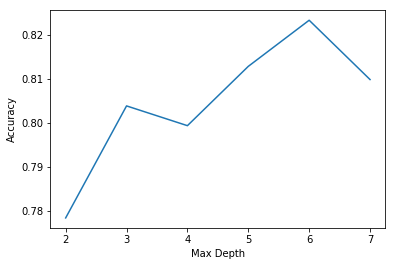

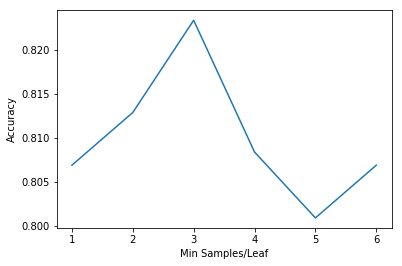

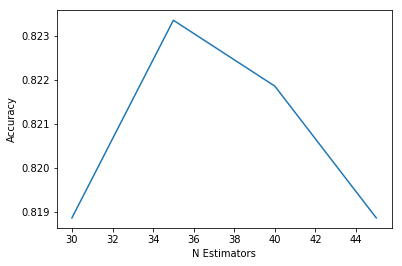

In [18]:
md_vals = [search.cv_results_['params'][i]['rfc__max_depth'] for i in range(len(search.cv_results_['params']))
          if abs(search.cv_results_['params'][i]['rfc__min_samples_leaf'] - search.best_params_['rfc__min_samples_leaf']) <= 0.1 and abs(search.cv_results_['params'][i]['rfc__n_estimators'] - search.best_params_['rfc__n_estimators']) <= 0.1]
scores = [search.cv_results_['mean_test_score'][i] for i in range(len(search.cv_results_['params']))
          if abs(search.cv_results_['params'][i]['rfc__min_samples_leaf'] - search.best_params_['rfc__min_samples_leaf']) <= 0.1 and abs(search.cv_results_['params'][i]['rfc__n_estimators'] - search.best_params_['rfc__n_estimators']) <= 0.1]

plt.figure()
plt.plot(md_vals,scores)
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.show()

msl_vals = [search.cv_results_['params'][i]['rfc__min_samples_leaf'] for i in range(len(search.cv_results_['params']))
          if abs(search.cv_results_['params'][i]['rfc__max_depth'] - search.best_params_['rfc__max_depth']) <= 0.1 and abs(search.cv_results_['params'][i]['rfc__n_estimators'] - search.best_params_['rfc__n_estimators']) <= 0.1]
scores = [search.cv_results_['mean_test_score'][i] for i in range(len(search.cv_results_['params']))
          if abs(search.cv_results_['params'][i]['rfc__max_depth'] - search.best_params_['rfc__max_depth']) <= 0.1 and abs(search.cv_results_['params'][i]['rfc__n_estimators'] - search.best_params_['rfc__n_estimators']) <= 0.1]

plt.figure()
plt.plot(msl_vals,scores)
plt.xlabel('Min Samples/Leaf')
plt.ylabel('Accuracy')
plt.show()

ne_vals = [search.cv_results_['params'][i]['rfc__n_estimators'] for i in range(len(search.cv_results_['params']))
          if abs(search.cv_results_['params'][i]['rfc__max_depth'] - search.best_params_['rfc__max_depth']) <= 0.1 and abs(search.cv_results_['params'][i]['rfc__min_samples_leaf'] - search.best_params_['rfc__min_samples_leaf']) <= 0.1]
scores = [search.cv_results_['mean_test_score'][i] for i in range(len(search.cv_results_['params']))
          if abs(search.cv_results_['params'][i]['rfc__max_depth'] - search.best_params_['rfc__max_depth']) <= 0.1 and abs(search.cv_results_['params'][i]['rfc__min_samples_leaf'] - search.best_params_['rfc__min_samples_leaf']) <= 0.1]

plt.figure()
plt.plot(ne_vals,scores)
plt.xlabel('N Estimators')
plt.ylabel('Accuracy')
plt.show()

In [19]:
rfcpipe = Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),('rfc',RandomForestClassifier(n_estimators=35,max_depth=6,min_samples_leaf=3,random_state=53))]).fit(X,y)
sortind=np.argsort(rfcpipe['rfc'].feature_importances_)
for features, coefficients in zip(X.columns[sortind], rfcpipe['rfc'].feature_importances_[sortind]):
    print(features,coefficients)
print('Accuracy score with simple imputer = ',np.mean(cross_validate(rfcpipe, X, y, cv=5)['test_score']))

CabinLetter_T 0.0
CabinLetter_G 0.0
CabinLetter_F 0.0013184595129704655
CabinLetter_E 0.0034700230600675994
CabinLetter_D 0.0044375696308834684
CabinLetter_A 0.0066612914976579155
CabinLetter_C 0.008080157767687215
Embarked_Q 0.01004120637334776
Embarked_S 0.014080457382698029
CabinLetter_B 0.014305598695964773
Embarked_C 0.018560289117559383
Parch 0.028459202559119438
SibSp 0.05192948316421288
Pclass 0.108326790189726
Age 0.1205088614488558
Fare 0.15774167321669655
Sex_female 0.4520789363825528
Accuracy score with simple imputer =  0.8038828414319379


**Repeat with iterative imputer**

In [20]:
piperfci = Pipeline(steps=[('imputer', IterativeImputer()), ('scaler', MinMaxScaler()),('rfc',RandomForestClassifier(random_state = 53))])

param_grid = {
    'rfc__max_depth': [5,6,7,8,9],
    'rfc__min_samples_leaf' : [2,3,4,5,6],
    'rfc__n_estimators' : [60,70,80,100,110,120,130]
}
search = GridSearchCV(piperfci, param_grid,cv=3)
search.fit(X, y)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.822):
{'rfc__max_depth': 7, 'rfc__min_samples_leaf': 2, 'rfc__n_estimators': 120}


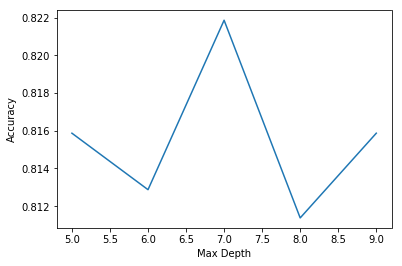

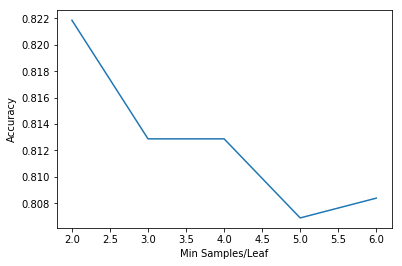

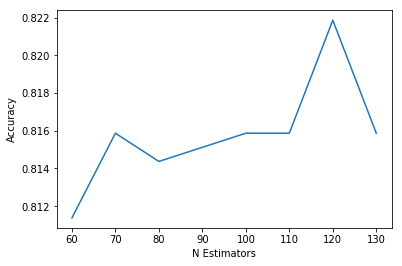

In [21]:
md_vals = [search.cv_results_['params'][i]['rfc__max_depth'] for i in range(len(search.cv_results_['params']))
          if abs(search.cv_results_['params'][i]['rfc__min_samples_leaf'] - search.best_params_['rfc__min_samples_leaf']) <= 0.1 and abs(search.cv_results_['params'][i]['rfc__n_estimators'] - search.best_params_['rfc__n_estimators']) <= 0.1]
scores = [search.cv_results_['mean_test_score'][i] for i in range(len(search.cv_results_['params']))
          if abs(search.cv_results_['params'][i]['rfc__min_samples_leaf'] - search.best_params_['rfc__min_samples_leaf']) <= 0.1 and abs(search.cv_results_['params'][i]['rfc__n_estimators'] - search.best_params_['rfc__n_estimators']) <= 0.1]

plt.figure()
plt.plot(md_vals,scores)
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.show()

msl_vals = [search.cv_results_['params'][i]['rfc__min_samples_leaf'] for i in range(len(search.cv_results_['params']))
          if abs(search.cv_results_['params'][i]['rfc__max_depth'] - search.best_params_['rfc__max_depth']) <= 0.1 and abs(search.cv_results_['params'][i]['rfc__n_estimators'] - search.best_params_['rfc__n_estimators']) <= 0.1]
scores = [search.cv_results_['mean_test_score'][i] for i in range(len(search.cv_results_['params']))
          if abs(search.cv_results_['params'][i]['rfc__max_depth'] - search.best_params_['rfc__max_depth']) <= 0.1 and abs(search.cv_results_['params'][i]['rfc__n_estimators'] - search.best_params_['rfc__n_estimators']) <= 0.1]

plt.figure()
plt.plot(msl_vals,scores)
plt.xlabel('Min Samples/Leaf')
plt.ylabel('Accuracy')
plt.show()

ne_vals = [search.cv_results_['params'][i]['rfc__n_estimators'] for i in range(len(search.cv_results_['params']))
          if abs(search.cv_results_['params'][i]['rfc__max_depth'] - search.best_params_['rfc__max_depth']) <= 0.1 and abs(search.cv_results_['params'][i]['rfc__min_samples_leaf'] - search.best_params_['rfc__min_samples_leaf']) <= 0.1]
scores = [search.cv_results_['mean_test_score'][i] for i in range(len(search.cv_results_['params']))
          if abs(search.cv_results_['params'][i]['rfc__max_depth'] - search.best_params_['rfc__max_depth']) <= 0.1 and abs(search.cv_results_['params'][i]['rfc__min_samples_leaf'] - search.best_params_['rfc__min_samples_leaf']) <= 0.1]

plt.figure()
plt.plot(ne_vals,scores)
plt.xlabel('N Estimators')
plt.ylabel('Accuracy')
plt.show()

In [22]:
rfcpipei = Pipeline(steps=[('imputer', IterativeImputer()), ('scaler', MinMaxScaler()),('rfc',RandomForestClassifier(n_estimators=120,max_depth=7,min_samples_leaf=2,random_state=53))]).fit(X,y)

sortind=np.argsort(rfcpipei['rfc'].feature_importances_)
for features, coefficients in zip(X.columns[sortind], rfcpipei['rfc'].feature_importances_[sortind]):
    print(features,coefficients)
print('Accuracy score with iterative imputer = ',np.mean(cross_validate(rfcpipei, X, y, cv=5)['test_score']))

CabinLetter_T 0.00012911057454725628
CabinLetter_G 0.000689664682804012
CabinLetter_F 0.003031361395034654
CabinLetter_D 0.005046593887269141
CabinLetter_E 0.005553862553346387
CabinLetter_A 0.00844447957563323
CabinLetter_C 0.010791745412837984
Embarked_Q 0.013428106493744846
CabinLetter_B 0.015322733980886901
Embarked_C 0.015758030181069586
Embarked_S 0.017469456118918647
Parch 0.031711921139216656
SibSp 0.05203434670339909
Pclass 0.10842457692277713
Age 0.127260428923714
Fare 0.15111437970108205
Sex_female 0.4337892017537184
Accuracy score with iterative imputer =  0.8173717876781506


> **Now that the iterative imputer with random forest has been shown to give best results, train and apply to test set**

In [23]:
rfcpipe = Pipeline(steps=[('imputer', IterativeImputer()), ('scaler', MinMaxScaler()),('rfc',RandomForestClassifier(n_estimators=120,max_depth=7,min_samples_leaf=2,random_state=53))]).fit(X,y)
y_test_predict = rfcpipe.predict(X_test)

print('Final accuracy score : ',accuracy_score(y_test,y_test_predict))

Final accuracy score :  0.8251121076233184
